In [1]:
import numpy as np
import pipeline as pipe

from src.pipelines.build_pipelines import CustomPipeline, get_best_steps
from src.features import build_features
from src.features.build_features import *
from src.data import configuration as config
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# Prediction Models

Später dann zum zusammenführen  
•	VotingClassifier  
•	StackingClassifier   
•	BaggingClassifier  
•	AdaBoostClassifier

Lineare Modelle:  Marco  
•   LinearRegression/Ridge  
•	Lasso*    
•	ElasticNet*   
•	OrthogonalMatchingPursuit*  

Naive Bayes:  Patrick  
•	BernoulliNB  
•	ComplementNB  
•	GaussianNB  
•	MultinomialNB  

Nearest Neighbors:  Marco  
•	KNeighborsClassifier  
•	RadiusNeighborsClassifier   

Decision Trees:  Thomas  
•	DecisionTreeClassifier  
•	ExtraTreeClassifier  
•   LGBMClassifier       
•	RandomForestClassifier  

Support Vector Machines:  Patrick  
•	LinearSVC  
•	LinearSVR  
•	NuSVC  
•	NuSVR  
•	OneClassSVM  
•	SVC  
•	SVR  

Neural Networks:  Thomas  
•	MLPClassifier  
•	MLPRegressor  

## Baseline
For our baseline we use a dummy classifier

In [10]:
from sklearn.dummy import DummyClassifier

# create a dummy classifier that predicts the most frequent class
estimator = DummyClassifier(strategy='most_frequent')
baseline_pipe = CustomPipeline(get_best_steps(customEstimator=estimator), skip_feature_evaluation=True)
baseline_pipe.run()

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 2.978378915786743
    score_time: 0.2813164234161377
    test_accuracy: 0.5253234821387688
    test_f1-score: 0.22960090661128757
    test_mcc: 0.0
storing model and prediction


The dummy classifier scores an accuracy score of 0.525, an f1-score of 0.229 and an mcc score of 0

## Linear Models
Linear regression is used to predict a continuous variable. In our case we have a categorical variable with the values 1, 2 or 3. Therefore linear regression is not suitable.

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In the following we try out this model

In [17]:
from sklearn.linear_model import LogisticRegression

# create an instance of the model
estimator = LogisticRegression(multi_class='auto')

testpip = CustomPipeline(get_best_steps(customEstimator=estimator))
testpip.run()

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 4.572189617156982
    score_time: 0.30075798034667967
    test_accuracy: 0.6142060896201024
    test_f1-score: 0.4446026802480995
    test_mcc: 0.23982440663111518
storing model and prediction


An accuracy of 0.539 and an F1-score of 0.345 indicate that the model is not able to make accurate predictions, and an MCC of 0.078 suggests that the model's performance is only slightly better than random guessing.

In [18]:
# try out with only the numerical values
estimator = LogisticRegression(multi_class='auto')

feature_remover = RemoveFeatureTransformer(config.categorical_columns)

testpip = CustomPipeline([
    ('feature_remover', feature_remover),
    ('estimator', estimator)
])
testpip.run()

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 2.0311621189117433
    score_time: 0.03686342239379883
    test_accuracy: 0.5450873174440053
    test_f1-score: 0.34585481193609197
    test_mcc: 0.08855250469203477
storing model and prediction


Dropping the categorical columns improved the score only very slightly. We conclude that using a linear model is not suitable for our data task.

## Nearest Neighboor

### k-Nearest Neighboor
k-Nearest neighbor is a type of machine learning algorithm used for classification tasks. In the case of classification, the algorithm works by comparing an input sample to the training samples and finding the k-nearest neighbors based on a distance metric. The algorithm then classifies the input sample based on the most common class among its k-nearest neighbors. Nearest neighbor is a non-parametric algorithm, meaning it does not make any assumptions about the underlying distribution of the data. The number of neighbors k is a hyperparameter that can be tuned to optimize the algorithm's performance on a given dataset.
In the following we try out the algorithm with different k's to find out the best k for our task.

Knn requires the data to be fully numerical to calculate a distance metric. First we check whether this is fullfilled with our current transformations in the pipeline.

In [19]:
# check whether all columns are numerical
steps = get_best_steps()
steps.pop()

testpip = CustomPipeline(steps)
testpip.load_and_prep_data()
transformeddf = testpip.pipeline.fit_transform(testpip.X_train, testpip.y_train)

print(transformeddf.dtypes)

count_floors_pre_eq_0                       int64
count_floors_pre_eq_1                       int64
area_percentage_0                           int64
area_percentage_1                           int64
height_percentage_0                         int64
height_percentage_1                         int64
count_families_0                            int64
geo_level_1_id_0                            int64
geo_level_1_id_1                            int64
geo_level_1_id_2                            int64
geo_level_1_id_3                            int64
geo_level_2_id_0                            int64
geo_level_2_id_1                            int64
geo_level_2_id_2                            int64
geo_level_2_id_3                            int64
geo_level_2_id_4                            int64
geo_level_2_id_5                            int64
geo_level_2_id_6                            int64
geo_level_2_id_7                            int64
geo_level_2_id_8                            int64


Looking at the data above. Every feature is encoded numerically. In the next step we try out different k's for our algorithm.

In [20]:
bestScore = {}
bestRadius = 0
# create a loop to try out different k's
for radius in range(2,10):  
    
    # put the k from the loop into the classifier instance  
    estimator = KNeighborsClassifier(n_neighbors=radius)
    
    # create the pipeline and fit it with the classifier
    testpip = CustomPipeline(
        get_best_steps(customEstimator=estimator),
        skip_evaluation=False,
        print_evaluation=False,
        skip_storing_prediction=True)
    testpip.run()
    
    # check for the highest scoring
    if len(bestScore) <= 0:
        bestScore = testpip.evaluation_scoring
        bestRadius = radius
        
    elif bestScore['test_mcc'].mean() < testpip.evaluation_scoring['test_mcc'].mean():
        bestScore = testpip.evaluation_scoring
        bestRadius = radius

# print highest scoring with the k
print(f'The best score was achieved with k of {bestRadius}:')
for score in bestScore:
    print('    ' + score + ':', bestScore[score].mean())

loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
loading data
preparing data
running pipeline
evaluating pipeline
The best score was achieved with k of 9:
    fit_time: 3.3161951541900634
    score_time: 80.56746263504029
    test_accuracy: 0.7313508280387261
    test_f1-score: 0.6294216513179536
    test_mcc: 0.47901589939540495


The best knn score that was achieved is with an k of 9 with an mcc score of 0.479, a test accuracy of 0.731 and an f1 score of 0.629. This score is rather high. In the following we would like to try out ensamble methods on this classifier.


In [15]:
# initialize bagging classifier
base_clf = KNeighborsClassifier(n_neighbors=9)

bag_clf = BaggingClassifier(
    base_estimator=base_clf, # The base classifier
    n_estimators=10, # Number of estimators
    random_state=42 # For reproducibility
)

testpip = CustomPipeline(get_best_steps(customEstimator=bag_clf), skip_storing_prediction=True)
testpip.run()

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 2.227991008758545
    score_time: 87.4251254081726
    test_accuracy: 0.7338076764828357
    test_f1-score: 0.6321950291723432
    test_mcc: 0.4832389450558809
storing model and prediction


KeyboardInterrupt: 

### Nearest Centroid Classifier
This algorithm is a simple classification algorithm that uses the mean of each class as the centroid. The algorithm assigns the class label of the closest centroid to the query point.
The Nearest Centroid Classifier assumes that the data has a centroid-based structure, which may not be the case for all datasets. It is generally best suited for high-dimensional datasets with relatively few classes. Lets see how it performs on our data.

In [9]:
from sklearn.neighbors import NearestCentroid

# create an instance of the model
estimator = NearestCentroid()

testpip = CustomPipeline(get_best_steps(customEstimator=estimator))
testpip.run()

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 1.7741555213928222
    score_time: 0.15553750991821289
    test_accuracy: 0.4869426875796303
    test_f1-score: 0.4010608075834483
    test_mcc: 0.18115374119235145
storing model and prediction


An accuracy of 0.486 and an F1-score of 0.401 indicate that the model is not able to make accurate predictions, and an MCC of 0.181 suggests that the model's performance is rather poor. We conclude that the model is not suited for our data.

## Support Vector Machine

If SVM is used for Classification, there are many ways to separate the two sets. Which separation is the optimal solution to the problem? The bigger the size of the margin, the better the generalization. SVM finds the best separation hyperplane with maximum margin to the classes. Support vectors have a direct influence on the position of the hyperplane. 

SVC supports both linear and non-linear decision boundaries. It projects the data into a higher-dimensional space where they may be linearly separable. SVC can capture more complex decision boundaries and is better suited for problems where the data is not linearly separable.

In [ ]:
from sklearn.svm import SVC

testpip = CustomPipeline(get_best_steps(customEstimator=SVC(kernel='rbf')), force_cleaning=False)
testpip.run()

LinearSVC implements a linear support vector machine (SVM) for classification. It is used, when a simple linear decision boundary is sufficient.

In [ ]:
from sklearn.svm import LinearSVC

testpip = CustomPipeline(get_best_steps(customEstimator=LinearSVC()), force_cleaning=False)
testpip.run()

The result is noticeably worse compared to SVC, which indicates the problem is not simply solvable linearly. 

## Naiver Bayes

The Naive Bayes classifier is based on the Bayes theorem. It assumes that the features are independent of each other.The classifier calculates the probabilities for each class, given the values of the features, and selects the class with the highest probability as the prediction.

The MultinomialNB classifier is specifically designed for problems with discrete features and a multinomial distribution of the target variable. It is well suited for classification tasks where the features take on discrete values that are divided into more than two categories or expressions.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

testpip = CustomPipeline(get_best_steps(customEstimator=MultinomialNB()), force_cleaning=False)
testpip.run()

The quality of the prediction is better than the baseline.

## DecisionTreeClassifier

fit_time: 3.258013296127319
score_time: 0.2707803249359131
test_accuracy: 0.7044350430337691
test_f1-score: 0.6088604443801355
test_mcc: 0.4313301744900452


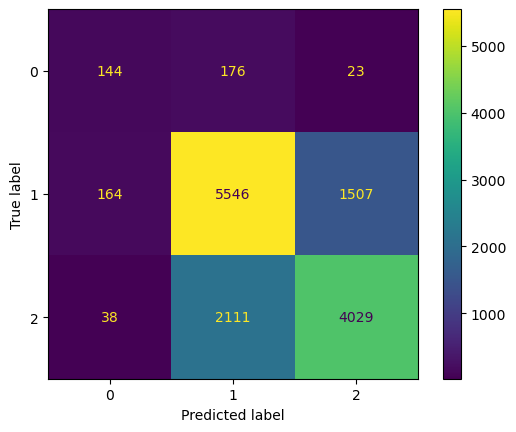

               feature  importance
0     geo_level_1_id_2    0.100620
1     geo_level_1_id_0    0.063806
2     geo_level_1_id_3    0.040377
3     geo_level_1_id_1    0.038491
4     geo_level_2_id_1    0.032904
5  height_percentage_0    0.028340
6     geo_level_2_id_2    0.027928
7           position_0    0.027693
8  height_percentage_1    0.027205
9    area_percentage_0    0.026564
                                     feature  importance
47  has_superstructure_cement_mortar_brick_1    0.001889
48                       has_secondary_use_1    0.001798
49  has_superstructure_cement_mortar_brick_0    0.001794
50                     count_floors_pre_eq_0    0.000176
51                       has_secondary_use_0    0.000118
52                     count_floors_pre_eq_1    0.000054
53                  land_surface_condition_0    0.000000
54                          count_families_0    0.000000
55                       ground_floor_type_0    0.000000
56                         foundation_type_0 

In [2]:
from sklearn.tree import DecisionTreeClassifier

pipeline = CustomPipeline(
    get_best_steps(
        customEstimator=DecisionTreeClassifier()
    ), 
    skip_error_evaluation=False,
    skip_feature_evaluation=False, 
    skip_storing_prediction=True
)
pipeline.run()

fit_time: 2.6776978969573975
score_time: 0.2815742492675781
test_accuracy: 0.6231597384463626
test_f1-score: 0.39944670712117003
test_mcc: 0.2678627235909429


[Text(0.5, 0.8333333333333334, 'geo_level_1_id_1 <= 0.5\ngini = 0.521\nsamples = 54949\nvalue = [1373, 28866, 24710]'),
 Text(0.25, 0.5, 'geo_level_1_id_0 <= 0.5\ngini = 0.492\nsamples = 27944\nvalue = [1076, 17608, 9260]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.498\nsamples = 12608\nvalue = [86, 7097, 5425]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.464\nsamples = 15336\nvalue = [990, 10511, 3835]'),
 Text(0.75, 0.5, 'geo_level_1_id_3 <= 0.5\ngini = 0.499\nsamples = 27005\nvalue = [297, 11258, 15450]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.514\nsamples = 14804\nvalue = [283, 7944, 6577]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.397\nsamples = 12201\nvalue = [14, 3314, 8873]')]

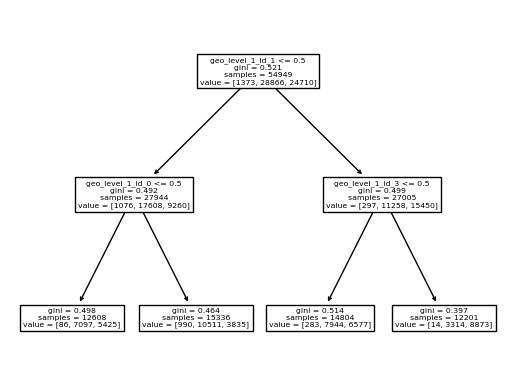

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

pipeline = CustomPipeline(
    get_best_steps(
        customEstimator=DecisionTreeClassifier(
            max_depth=3
        )
    ), 
    skip_error_evaluation=True,
    skip_feature_evaluation=True, 
    skip_storing_prediction=True
)
pipeline.run()

clf = pipeline.pipeline.named_steps['estimator']

plot_tree(
    decision_tree=clf,
    feature_names=clf.feature_names_in_
)

## RandomForestClassifier

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 13.512998247146607
    score_time: 0.6869125366210938
    test_accuracy: 0.7197947289667035
    test_f1-score: 0.6206372467421943
    test_mcc: 0.4569712749923359


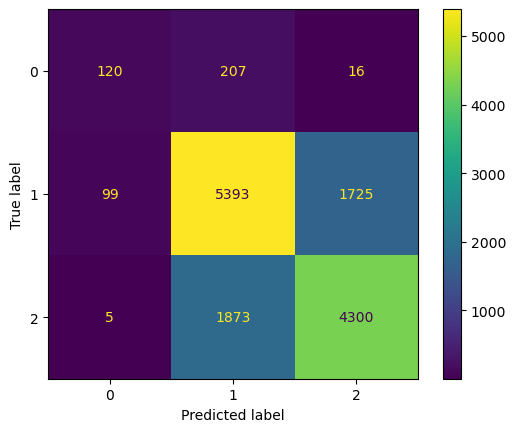

            feature  importance
0  geo_level_1_id_2    0.049355
1  geo_level_1_id_3    0.038230
2  geo_level_1_id_1    0.036620
3  geo_level_1_id_0    0.033062
4        position_0    0.027983
5        position_1    0.027406
6  geo_level_2_id_7    0.027286
7  geo_level_2_id_6    0.026075
8  geo_level_2_id_4    0.025815
9       roof_type_1    0.025790
                                     feature  importance
47  has_superstructure_cement_mortar_stone_1    0.002056
48  has_superstructure_cement_mortar_brick_1    0.001760
49  has_superstructure_cement_mortar_brick_0    0.001743
50                       has_secondary_use_0    0.000103
51                     count_floors_pre_eq_0    0.000073
52                     count_floors_pre_eq_1    0.000071
53                         foundation_type_0    0.000000
54                  land_surface_condition_0    0.000000
55                          count_families_0    0.000000
56                       ground_floor_type_0    0.000000


In [2]:
from sklearn.ensemble import RandomForestClassifier

pipeline = CustomPipeline(
    get_best_steps(
        customEstimator=RandomForestClassifier()
    ), 
    skip_error_evaluation=False,
    skip_feature_evaluation=False,
    skip_storing_prediction=True
)
pipeline.run()

## LightGBM

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 4.738079643249511
    score_time: 0.43484063148498536
    test_accuracy: 0.7316966515692629
    test_f1-score: 0.616476073422465
    test_mcc: 0.47713485021831065


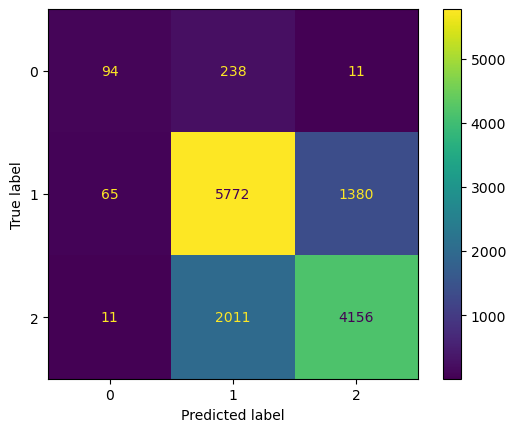

            feature  importance
0  geo_level_1_id_1         398
1  geo_level_1_id_2         371
2  geo_level_2_id_8         360
3  geo_level_2_id_7         345
4  geo_level_2_id_1         339
5  geo_level_2_id_2         328
6  geo_level_2_id_5         322
7  geo_level_2_id_6         315
8  geo_level_2_id_3         311
9  geo_level_2_id_0         305
                           feature  importance
47                      position_1          17
48               area_percentage_1          17
49  has_superstructure_adobe_mud_1          12
50             has_secondary_use_0           0
51               foundation_type_0           0
52                count_families_0           0
53           count_floors_pre_eq_1           0
54        land_surface_condition_0           0
55             ground_floor_type_0           0
56           count_floors_pre_eq_0           0


In [3]:
from lightgbm import LGBMClassifier

pipeline = CustomPipeline(
    get_best_steps(
        customEstimator=LGBMClassifier()
    ), 
    skip_error_evaluation=False,
    skip_feature_evaluation=False, 
    skip_storing_prediction=True
)
pipeline.run()

## Multi-Layer Perceptron Classifier (Neural Network)

loading data
preparing data
running pipeline
evaluating pipeline
    fit_time: 221.561194229126
    score_time: 0.524695634841919
    test_accuracy: 0.722178764089592
    test_f1-score: 0.6207326619998875
    test_mcc: 0.46426430296130705


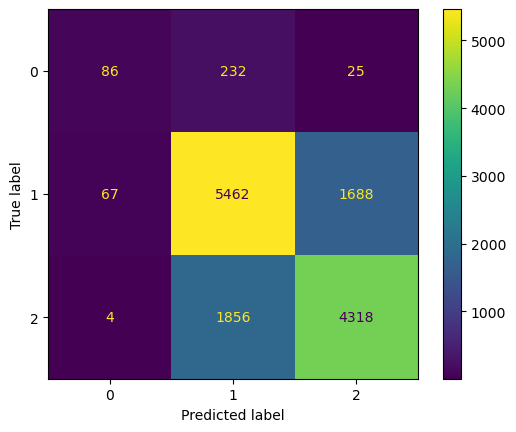

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [4]:
from sklearn.neural_network import MLPClassifier

pipeline = CustomPipeline(
    get_best_steps(
        customEstimator=MLPClassifier()
    ), 
    skip_error_evaluation=False,
    skip_feature_evaluation=False, 
    skip_storing_prediction=True
)
pipeline.run()